# ColorChecker를 이용한 보정

## 수동으로 ColorChecker ROI 지정

In [42]:
import cv2
import numpy as np

image_path = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\manual\4W_L_1B_1.jpg"

# 이미지 로드
with open(image_path, 'rb') as f:
    file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

# 원본 크기 저장
orig_h, orig_w = image.shape[:2]

# 축소 비율 계산
resize_width = 1500
scale = resize_width / orig_w
resize_height = int(orig_h * scale)

# 축소 이미지 생성
resized_image = cv2.resize(image, (resize_width, resize_height))
clone = resized_image.copy()

# 클릭 좌표 저장
points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        # 축소 비율로 원본 좌표 환산
        orig_x = int(x / scale)
        orig_y = int(y / scale)
        points.append((orig_x, orig_y))
        cv2.circle(param, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Click ColorChecker corners", param)

# 마우스 클릭 UI
cv2.imshow("Click ColorChecker corners", clone)
cv2.setMouseCallback("Click ColorChecker corners", click_event, clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 확인
if len(points) != 4:
    raise ValueError("❗ 꼭지점 4개를 클릭해야 합니다.")

print("✅ 원본 해상도 기준 클릭 좌표:", points)

✅ 원본 해상도 기준 클릭 좌표: [(2770, 760), (2794, 1117), (3040, 1093), (3021, 746)]


## ColorChecker 부분 추출을 위한 원근 변환 행렬 및 이미지 왜곡 보정 후 저장

In [44]:
# 순서 정렬: 좌상-우상-우하-좌하 순서 필요
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    return np.array([
        pts[np.argmin(s)],      # top-left
        pts[np.argmin(diff)],   # top-right
        pts[np.argmax(s)],      # bottom-right
        pts[np.argmax(diff)]    # bottom-left
    ], dtype="float32")

src_pts = sort_corners(points)

# 대상 크기 설정 (예: 600x400 픽셀)
width, height = 600, 400
dst_pts = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")

# 원근 변환
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(image, M, (width, height))

cv2.imwrite(r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\cal_only_one\colorchecker_roi.jpg", warped)

False

## 색 변환을 위해 ColorChecker 내 색상을 읽는 순서 설정

- D65 공식 색상표 참조: https://xritephoto.com/documents/literature/en/ColorData-1p_EN.pdf

In [45]:
H, W, _ = warped.shape

rows, cols = 6, 4
patch_h = H // rows
patch_w = W // cols

observed_colors = []

for col in range(cols):  # 왼쪽 → 오른쪽
    for row in reversed(range(rows)):  # 아래 → 위
        y1 = row * patch_h
        y2 = (row + 1) * patch_h
        x1 = col * patch_w
        x2 = (col + 1) * patch_w
        patch = warped[y1:y2, x1:x2]
        mean_color = patch.mean(axis=(0, 1))  # BGR
        observed_colors.append(mean_color[::-1])  # RGB

## 색상 매트릭스 선형 학습

In [46]:
from sklearn.linear_model import LinearRegression

observed_colors = np.array(observed_colors, dtype=np.float32)

# D65 기준 레퍼런스 (순서 동일해야 함)
reference_colors = np.array([
    [115, 82, 68], [194, 150, 130], [98, 122, 157], [87, 108, 67],
    [133, 128, 177], [103, 189, 170], [214, 126, 44], [80, 91, 166],
    [193, 90, 99], [94, 60, 108], [157, 188, 64], [224, 163, 46],
    [56, 61, 150], [70, 148, 73], [175, 54, 60], [231, 199, 31],
    [187, 86, 149], [8, 133, 161], [243, 243, 242], [200, 200, 200],
    [160, 160, 160], [122, 122, 121], [85, 85, 85], [52, 52, 52]
], dtype=np.float32)

# 보정 매트릭스 학습
reg = LinearRegression()
reg.fit(observed_colors, reference_colors)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 이미지 내 ColorChecker 색과 D65 색상 및 순서 비교

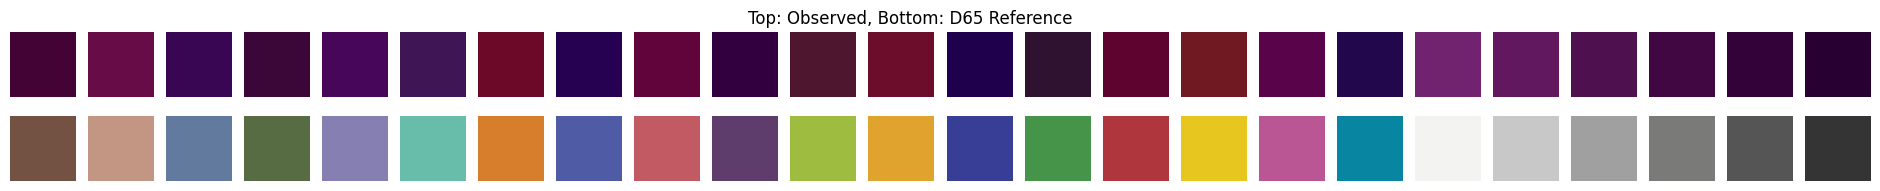

In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 24, figsize=(24, 2))
for i in range(24):
    axes[0, i].imshow([[observed_colors[i]/255]])
    axes[0, i].axis('off')
    axes[1, i].imshow([[reference_colors[i]/255]])
    axes[1, i].axis('off')
plt.suptitle("Top: Observed, Bottom: D65 Reference")
plt.show()

## 샘플 한 개의 원본 이미지 불러오기

In [36]:
import cv2
import numpy as np

path = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\manual\4W_L_1B_1.jpg"

with open(path, 'rb') as f:
    file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
    image_bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

if image_bgr is None:
    raise ValueError("❗ 이미지를 불러오지 못했습니다. 파일이 손상되었을 수 있습니다.")

# RGB 변환
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

## 원본 샘플의 전체 이미지에 보정 적용

In [37]:
from sklearn.linear_model import LinearRegression

# 예시: reg = LinearRegression().fit(observed_colors, reference_colors)
# 위에서 학습된 reg 사용

# 전체 이미지에 보정 적용
flat_rgb = image_rgb.reshape(-1, 3)
corrected_flat = reg.predict(flat_rgb)
corrected_rgb = np.clip(corrected_flat, 0, 255).reshape(image_rgb.shape).astype(np.uint8)

## 샘플 이미지 변환 결과 저장 및 출력

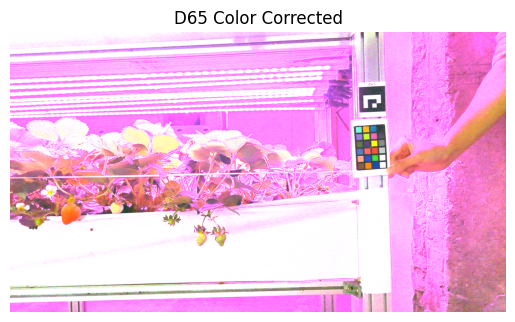

In [52]:
# 이미지 메모리 버퍼로 저장
success, buffer = cv2.imencode(".jpg", corrected_bgr)
if success:
    with open(r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\cal_only_one\corrected_image_d65.jpg", "wb") as f:
        f.write(buffer)


# 결과 보기 (optional)
import matplotlib.pyplot as plt
plt.imshow(corrected_rgb)
plt.title("D65 Color Corrected")
plt.axis('off')
plt.show()

## 폴더 내 이미지 전부에 적용

- 샘플 이미지에서 추출한 매트릭스로 전체 보정 해보기

In [53]:
import os
import cv2
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. 폴더 설정
input_dir = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\manual"
output_dir = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\4weeks\cal_only_one"
os.makedirs(output_dir, exist_ok=True)

# 2. 확장자 기준 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 3. 전제: 보정 모델이 이미 학습됨 (reg)
# 예시: reg = LinearRegression().fit(observed_colors, reference_colors)

for filename in image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 이미지 로드 (한글 경로 대응)
    with open(input_path, 'rb') as f:
        file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
        image_bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    if image_bgr is None:
        print(f"❌ 불러오기 실패: {filename}")
        continue

    # 색상 보정
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    flat_rgb = image_rgb.reshape(-1, 3)
    corrected_flat = reg.predict(flat_rgb)
    corrected_rgb = np.clip(corrected_flat, 0, 255).reshape(image_rgb.shape).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR)

    # 한글 경로 대응 저장 (cv2.imencode 방식)
    success, buffer = cv2.imencode(".jpg", corrected_bgr)
    if success:
        with open(output_path, "wb") as f:
            f.write(buffer)
        print(f"✅ 저장 완료: {filename}")
    else:
        print(f"❌ 저장 실패: {filename}")

✅ 저장 완료: 4W_L_1B_1.jpg
✅ 저장 완료: 4W_L_1B_2.jpg
✅ 저장 완료: 4W_L_1B_3.jpg
✅ 저장 완료: 4W_L_1B_4.jpg
✅ 저장 완료: 4W_L_1B_5.jpg
✅ 저장 완료: 4W_L_1B_6.jpg
✅ 저장 완료: 4W_L_1B_7.jpg
✅ 저장 완료: 4W_L_1B_8.jpg
✅ 저장 완료: 4W_L_1B_9.jpg
✅ 저장 완료: 4W_L_1B_10.jpg
✅ 저장 완료: 4W_L_1B_11.jpg
✅ 저장 완료: 4W_L_1B_12.jpg
✅ 저장 완료: 4W_L_1B_13.jpg
✅ 저장 완료: 4W_L_1B_14.jpg
✅ 저장 완료: 4W_L_1B_15.jpg
✅ 저장 완료: 4W_L_1B_16.jpg
✅ 저장 완료: 4W_L_1B_17.jpg
✅ 저장 완료: 4W_L_1B_18.jpg
✅ 저장 완료: 4W_L_1B_19.jpg
✅ 저장 완료: 4W_L_1B_20.jpg
✅ 저장 완료: 4W_L_1B_21.jpg
✅ 저장 완료: 4W_L_1B_22.jpg
✅ 저장 완료: 4W_L_1B_23.jpg
✅ 저장 완료: 4W_L_1B_24.jpg
✅ 저장 완료: 4W_L_2B_1.jpg
✅ 저장 완료: 4W_L_2B_2.jpg
✅ 저장 완료: 4W_L_2B_3.jpg
✅ 저장 완료: 4W_L_2B_4.jpg
✅ 저장 완료: 4W_L_2B_5.jpg
✅ 저장 완료: 4W_L_2B_6.jpg
✅ 저장 완료: 4W_L_2B_7.jpg
✅ 저장 완료: 4W_L_2B_8.jpg
✅ 저장 완료: 4W_L_2B_9.jpg
✅ 저장 완료: 4W_L_2B_10.jpg
✅ 저장 완료: 4W_L_2B_11.jpg
✅ 저장 완료: 4W_L_2B_12.jpg
✅ 저장 완료: 4W_L_2B_13.jpg
✅ 저장 완료: 4W_L_2B_14.jpg
✅ 저장 완료: 4W_L_2B_15.jpg
✅ 저장 완료: 4W_L_2B_16.jpg
✅ 저장 완료: 4W_L_2B_17.jpg
✅ 저장 완료: 4W_L_2B_18.jpg
✅ 저장 완료: 4

## 여러 경로 한 번에 수행하기

In [55]:
base_path = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\{}\manual"
output_path = r"F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\{}\cal_only_one"
folder_names = ["1weeks", "2weeks", "3weeks"]

for name in folder_names:
    path1 = base_path.format(name)
    print("📁 경로:", path1)
    path2 = output_path.format(name)
    print("📁 경로:", path2)

    # 1. 폴더 설정
    input_dir = path1
    output_dir = path2
    os.makedirs(output_dir, exist_ok=True)
    
    # 2. 확장자 기준 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # 3. 전제: 보정 모델이 이미 학습됨 (reg)
    # 예시: reg = LinearRegression().fit(observed_colors, reference_colors)

    for filename in image_files:
        input_path = os.path.join(input_dir, filename)
        save_path = os.path.join(output_dir, filename)

        # 이미지 로드 (한글 경로 대응)
        with open(input_path, 'rb') as f:
            file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
            image_bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        if image_bgr is None:
            print(f"❌ 불러오기 실패: {filename}")
            continue

        # 색상 보정
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        flat_rgb = image_rgb.reshape(-1, 3)
        corrected_flat = reg.predict(flat_rgb)
        corrected_rgb = np.clip(corrected_flat, 0, 255).reshape(image_rgb.shape).astype(np.uint8)
        corrected_bgr = cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR)

        # 한글 경로 대응 저장 (cv2.imencode 방식)
        success, buffer = cv2.imencode(".jpg", corrected_bgr)
        if success:
            with open(save_path, "wb") as f:
                f.write(buffer)
            print(f"✅ 저장 완료: {filename}")
        else:
            print(f"❌ 저장 실패: {filename}")

📁 경로: F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\1weeks\manual
📁 경로: F:\세종대학교\과제\딸기수직농장_1번과제\data\NEXTON\1weeks\cal_only_one
✅ 저장 완료: 1W_L_1B_1.JPG
✅ 저장 완료: 1W_L_1B_2.JPG
✅ 저장 완료: 1W_L_1B_3.JPG
✅ 저장 완료: 1W_L_1B_4.JPG
✅ 저장 완료: 1W_L_1B_5.JPG
✅ 저장 완료: 1W_L_1B_6.JPG
✅ 저장 완료: 1W_L_1B_7.JPG
✅ 저장 완료: 1W_L_1B_8.JPG
✅ 저장 완료: 1W_L_1B_9.JPG
✅ 저장 완료: 1W_L_1B_10.JPG
✅ 저장 완료: 1W_L_1B_11.JPG
✅ 저장 완료: 1W_L_1B_12.JPG
✅ 저장 완료: 1W_L_1B_13.JPG
✅ 저장 완료: 1W_L_1B_14.JPG
✅ 저장 완료: 1W_L_1B_15.JPG
✅ 저장 완료: 1W_L_1B_16.JPG
✅ 저장 완료: 1W_L_1B_17.JPG
✅ 저장 완료: 1W_L_1B_18.JPG
✅ 저장 완료: 1W_L_1B_19.JPG
✅ 저장 완료: 1W_L_1B_20.JPG
✅ 저장 완료: 1W_L_1B_21.JPG
✅ 저장 완료: 1W_L_1B_22.JPG
✅ 저장 완료: 1W_L_1B_23.JPG
✅ 저장 완료: 1W_L_1B_24.JPG
✅ 저장 완료: 1W_L_2B_1.JPG
✅ 저장 완료: 1W_L_2B_2.JPG
✅ 저장 완료: 1W_L_2B_3.JPG
✅ 저장 완료: 1W_L_2B_4.JPG
✅ 저장 완료: 1W_L_2B_5.JPG
✅ 저장 완료: 1W_L_2B_6.JPG
✅ 저장 완료: 1W_L_2B_7.JPG
✅ 저장 완료: 1W_L_2B_8.JPG
✅ 저장 완료: 1W_L_2B_9.JPG
✅ 저장 완료: 1W_L_2B_10.JPG
✅ 저장 완료: 1W_L_2B_11.JPG
✅ 저장 완료: 1W_L_2B_12.JPG
✅ 저장 완료: 1W_L_2B_13.JPG
✅ 저장 완료: 1W_